In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

sns.set_theme(style="whitegrid")
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import os
from unidecode import unidecode
import geojson

path_geodata = r"C:\Users\ade\OneDrive - TRANSITEC\D0-3_2301-Reseau_TC_Afrique\4b-SIG\ADE\layers\villes_africaines_points.csv"
path_img_fr = r"C:\Users\ade\OneDrive - TRANSITEC\D0-3_2301-Reseau_TC_Afrique\3-Ingenierie\ADE\transports_villes_africaines\img\fr"
path_img_en = r"C:\Users\ade\OneDrive - TRANSITEC\D0-3_2301-Reseau_TC_Afrique\3-Ingenierie\ADE\transports_villes_africaines\img\en"
path_excel = r"C:\Users\ade\OneDrive - TRANSITEC\D0-3_2301-Reseau_TC_Afrique\3-Ingenierie\BD\V1-Modes_of_Transport_per_City.xlsx"
path_geojson = r"C:\Users\ade\OneDrive - TRANSITEC\D0-3_2301-Reseau_TC_Afrique\3-Ingenierie\ADE\transports_villes_africaines\villes_africaines.geojson"
path_pictos = r"C:\Users\ade\OneDrive - TRANSITEC\D0-3_2301-Reseau_TC_Afrique\3-Ingenierie\ADE\transports_villes_africaines\pictos"

In [54]:
df_geodata = pd.read_csv(path_geodata)
df_geodata["Name"] = df_geodata["Name"].apply(lambda x: x.strip())

df_excel = pd.read_excel(
    path_excel, sheet_name="Tableau-actualisé-JANV-2025", header=[3], index_col=[0, 1, 2])

In [55]:
def format_number(n):
    if n >= 1_000_000:
        return f"{round(n / 1_000_000, 1)}M" 
    elif n >= 10_000:
        return f"{round(n / 1_000)}k"
    return str(n)

df_hab = df_excel.reset_index()[["Ville", "Nombre d'habitants en 2020 - Africapolis (agglomération)", "Nombre d'habitants en 2024 (ville)"]]
df_hab = df_hab.dropna()
df_hab['hab_agglo'] = df_hab["Nombre d'habitants en 2020 - Africapolis (agglomération)"].apply(format_number)
df_hab['hab_ville'] = df_hab["Nombre d'habitants en 2024 (ville)"].apply(format_number)

In [56]:
dict_hab_agglo = dict(zip(df_hab["Ville"], df_hab["hab_agglo"]))
dict_hab_ville = dict(zip(df_hab["Ville"], df_hab["hab_ville"]))

In [73]:
df_excel = df_excel.dropna(subset = ["KM d'infrastructure"])
df_excel = df_excel.reset_index()

df_excel = df_excel[["Ville", "Mode de transport", "Situation en 2024", "KM d'infrastructure"]]
df_excel['Ville'] = df_excel['Ville'].apply(lambda x: x.strip())

df_excel = df_excel.groupby(['Ville', 'Mode de transport', 'Situation en 2024']).sum().reset_index()

df_excel["hab_agglo"] = df_excel['Ville'].map(dict_hab_agglo)
df_excel["hab_ville"] = df_excel['Ville'].map(dict_hab_ville)

In [23]:
# check si toutes les villes ont bien des coordonnées
for x in df_excel['Ville'].unique():
    if x not in df_geodata['Name'].unique():
        print(x)

In [175]:
palette = {
    "planned / planifié": "#55c3ec",
    "under study": "#8d4192",
    "stand by after feasibility study": "#db203f",
    "under construction": "#ed6c27",
    "operational": "#a7c83e",
    "fully operational": "#369446"
} # else : #949599

mode_icons = {
    "BRT+BHNS": path_pictos + "\picto_bhns.png",
    "Funiculaire" : path_pictos + "\picto_funiculaire.png",
    "Métro": path_pictos + "\picto_metro.png",
    "RER": path_pictos + "\picto_rer.png",
    "Télécabines": path_pictos + "\picto_telecabines.png",
    "Train": path_pictos + "\picto_train.png",
    "Tramway": path_pictos + "\picto_tramway.png"
}

situation_order = [
    "planned / planifié",
    "under study",
    "stand by after feasibility study",
    "under construction",
    "operational",
    "fully operational"
]

transport_order = [
    "BRT+BHNS",
    "Funiculaire",
    "Métro",
    "RER",
    "Télécabines",
    "Train",
    "Tramway"
]

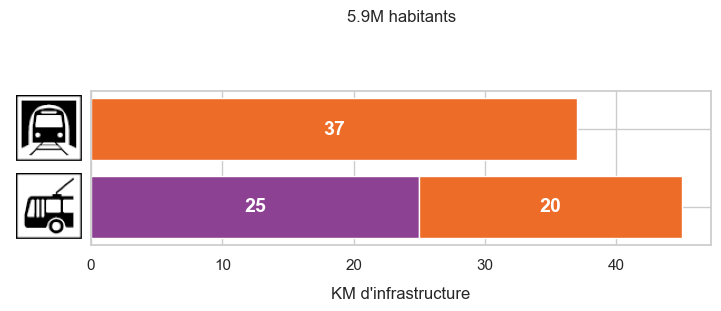

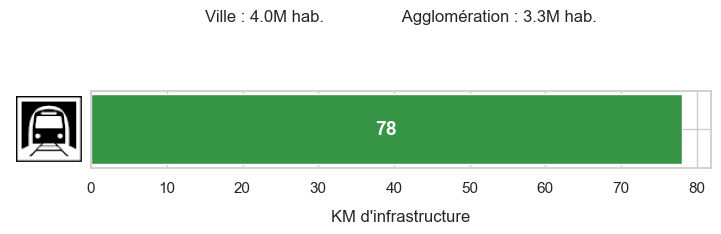

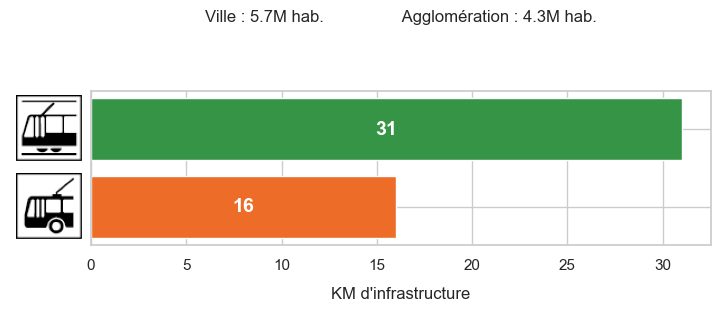

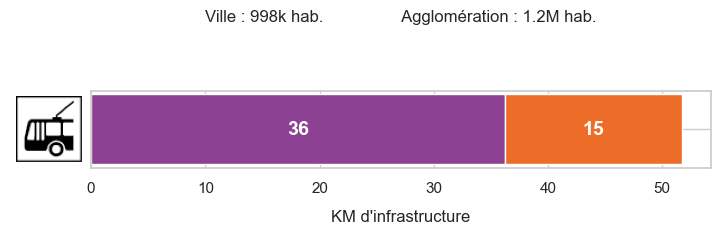

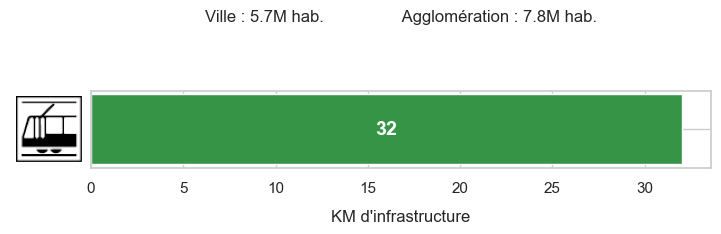

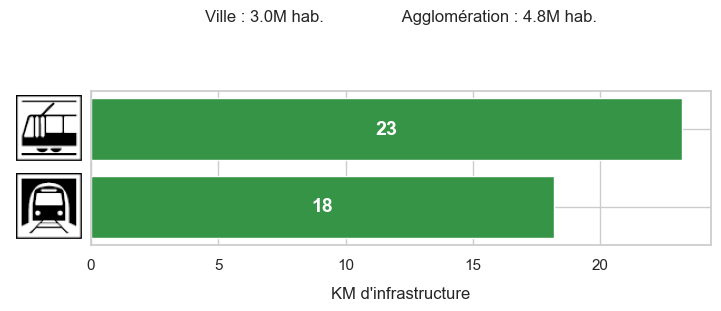

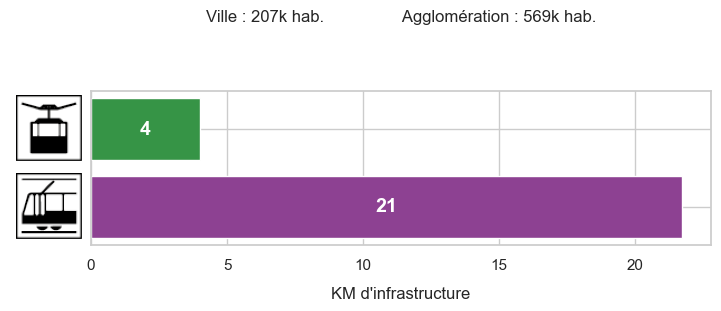

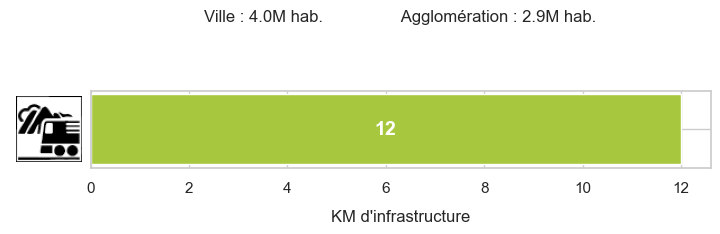

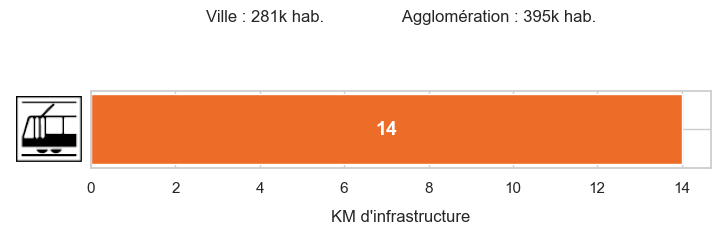

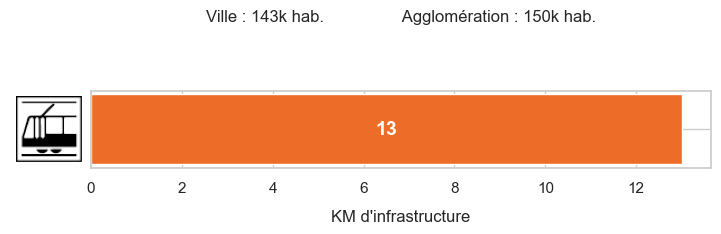

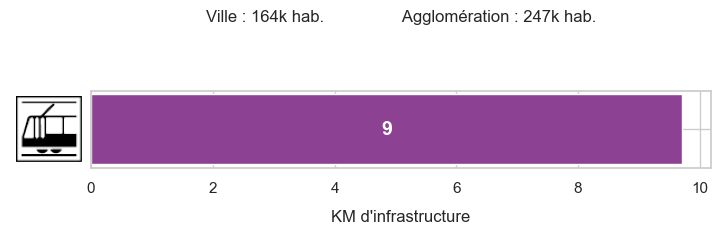

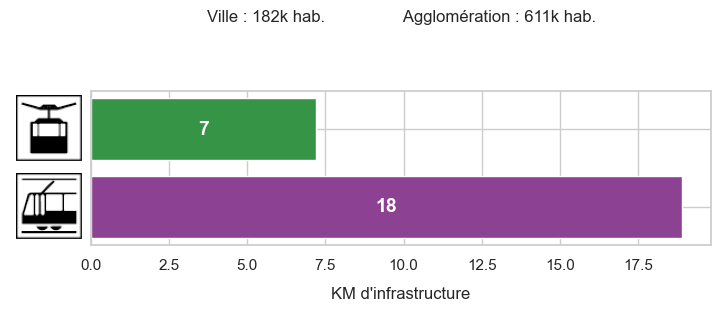

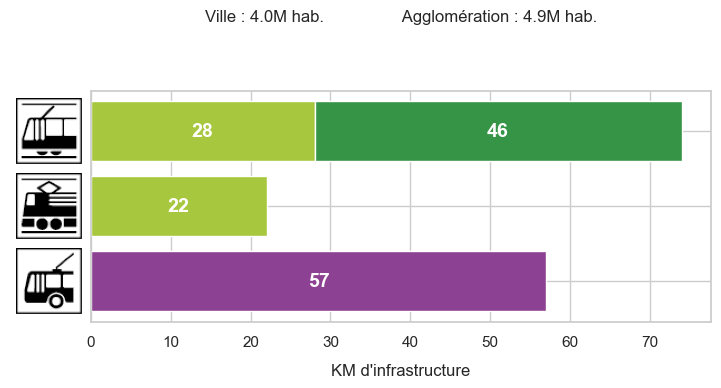

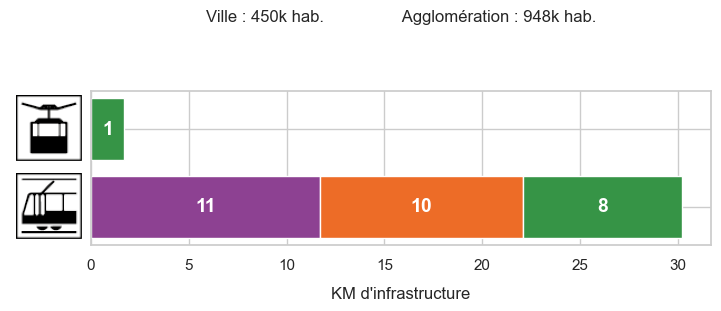

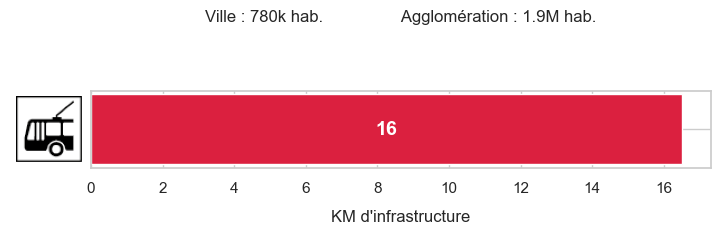

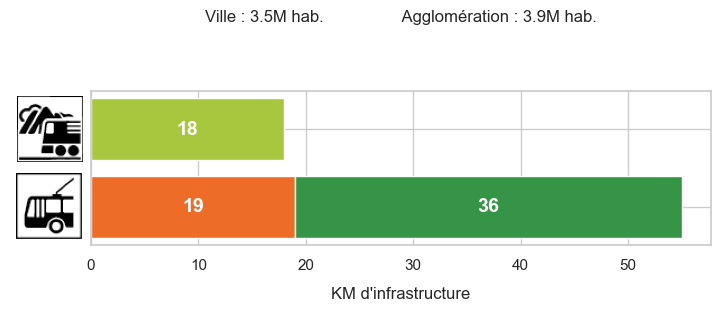

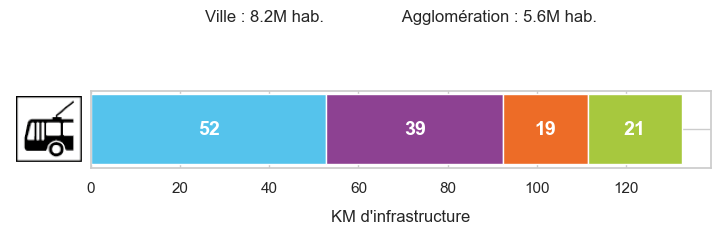

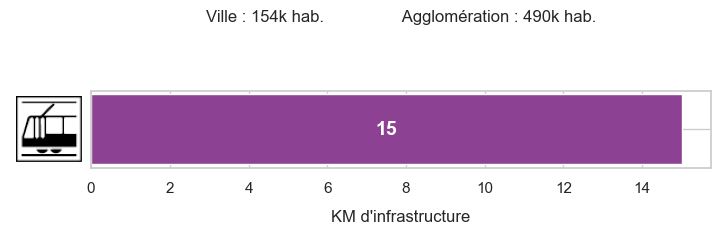

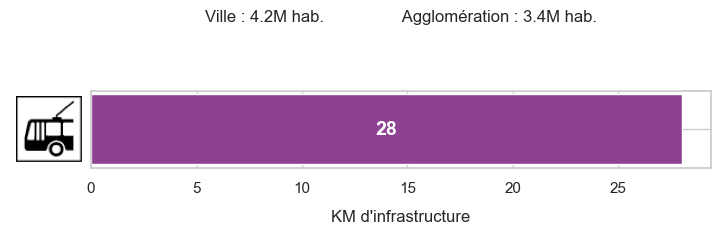

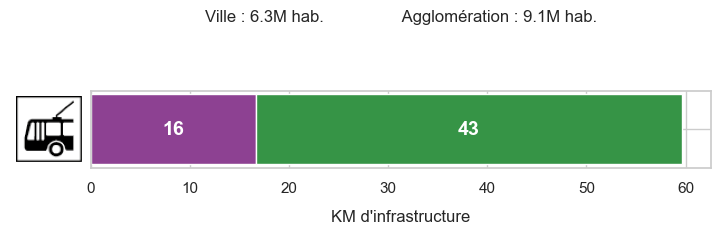

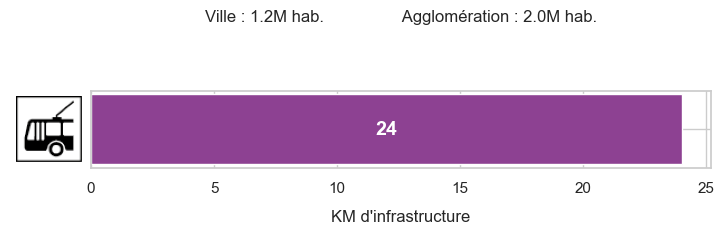

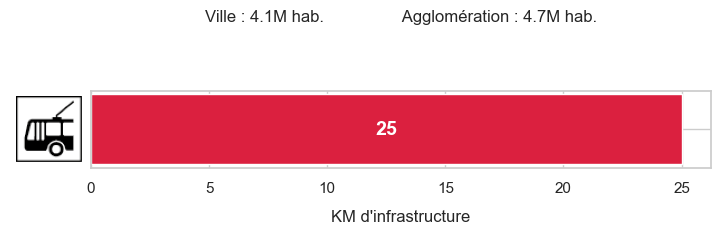

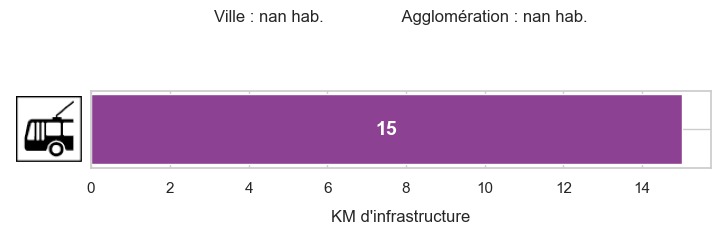

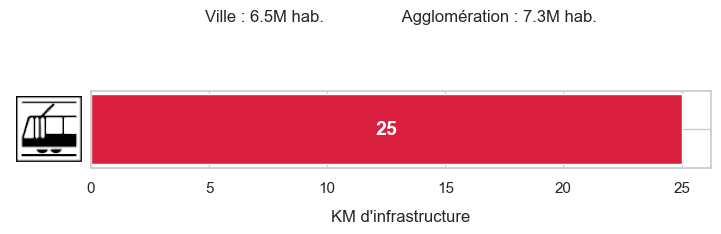

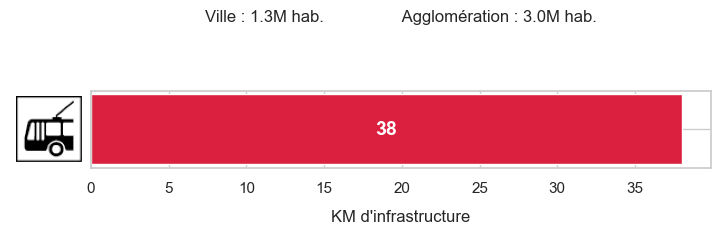

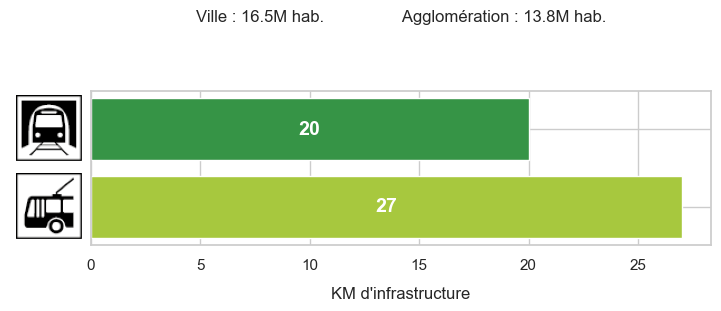

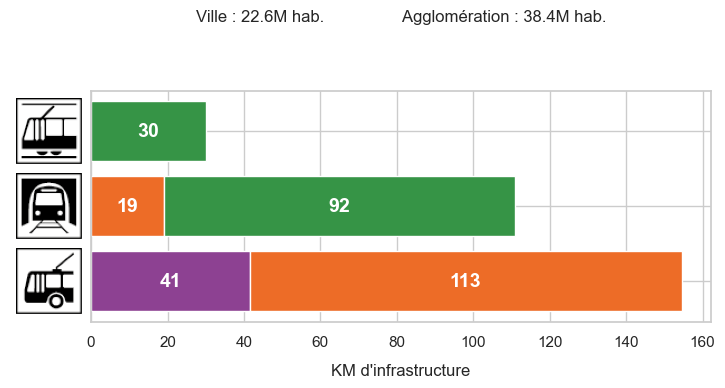

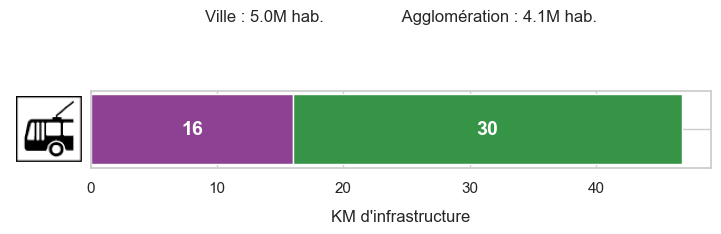

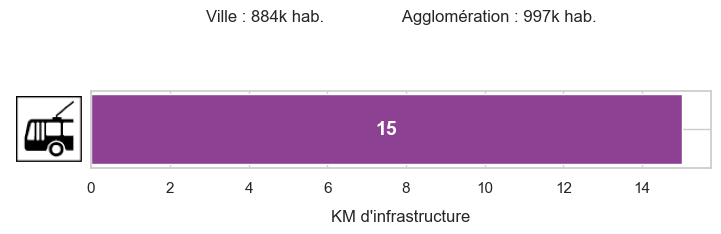

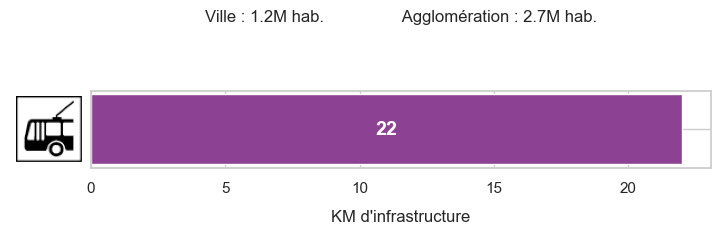

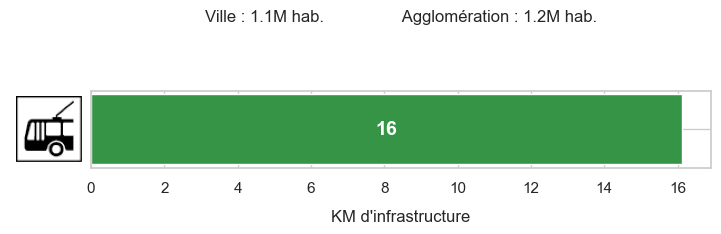

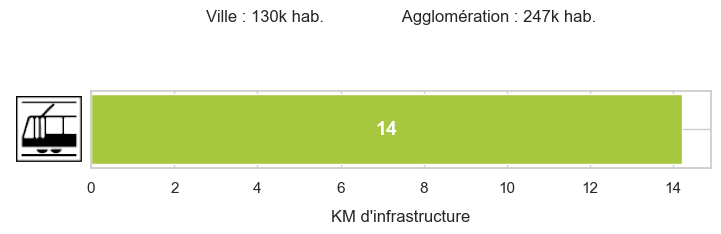

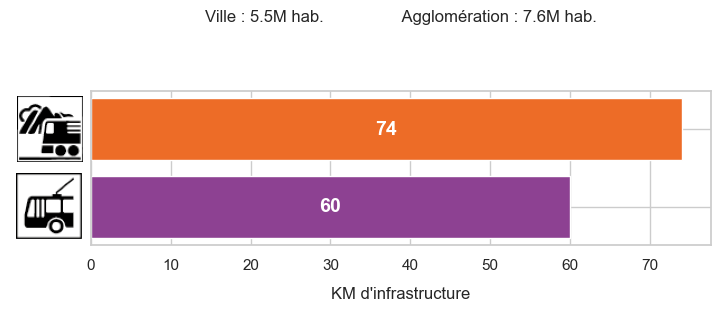

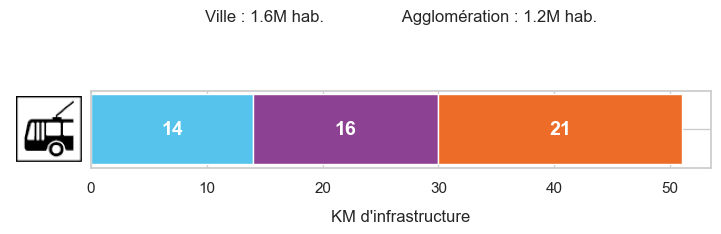

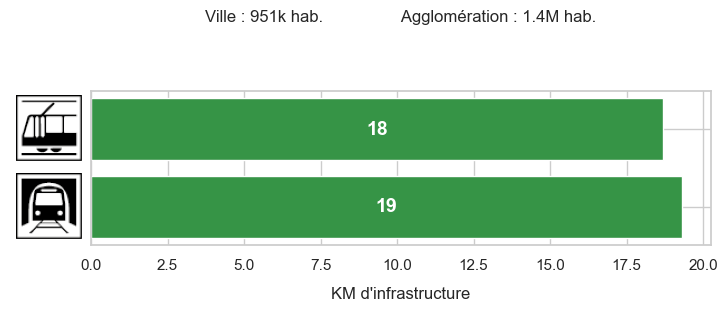

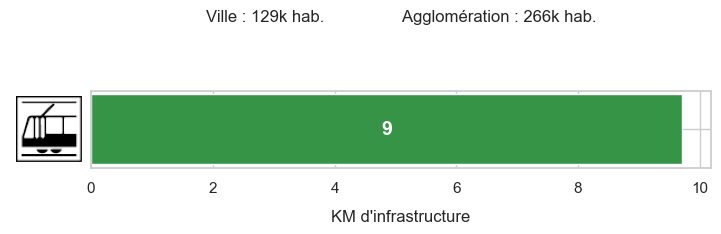

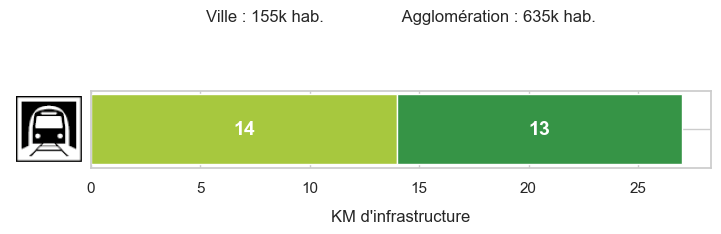

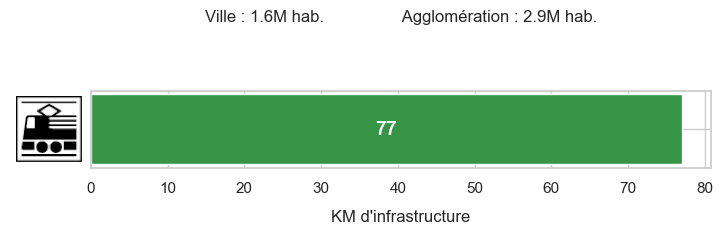

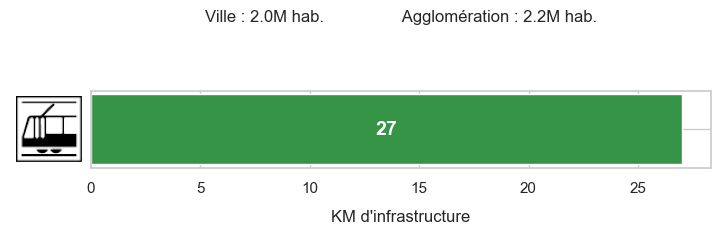

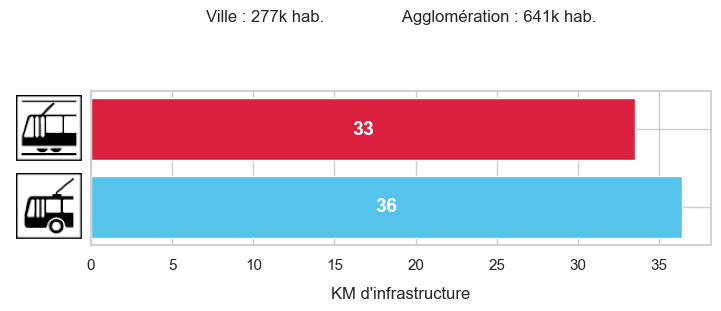

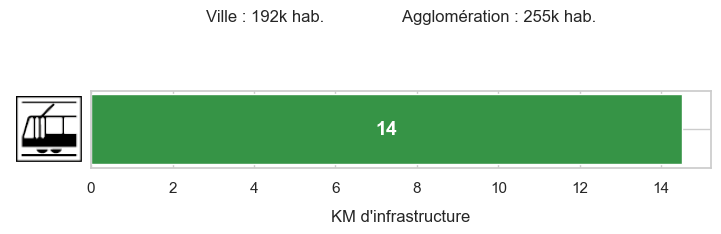

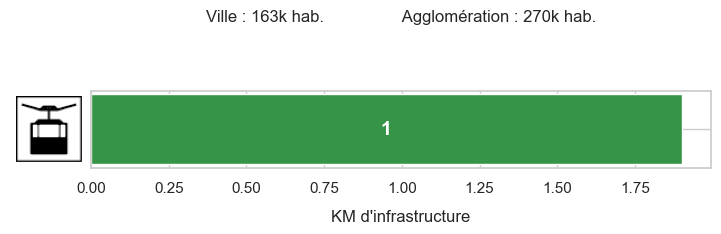

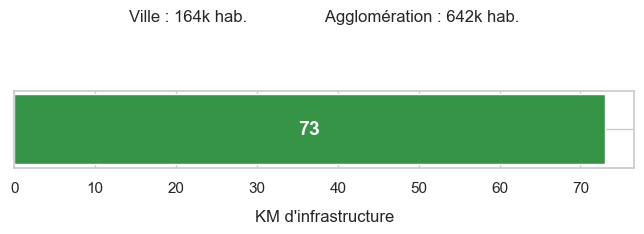

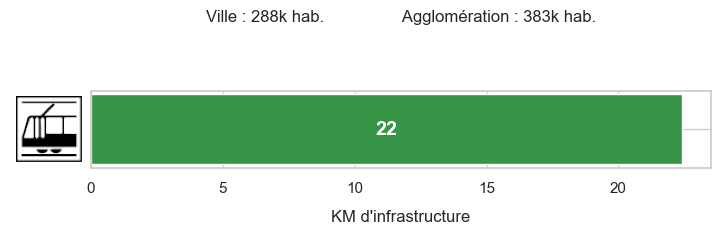

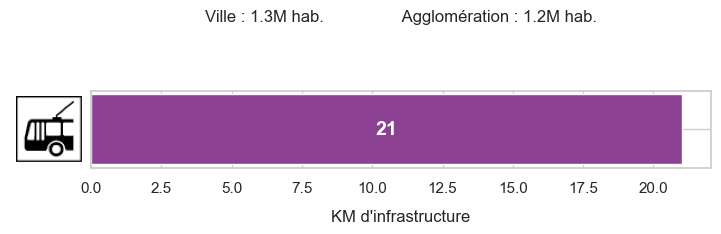

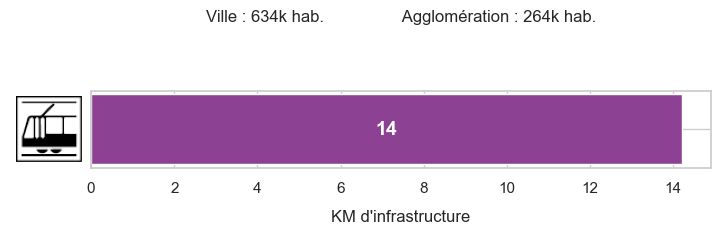

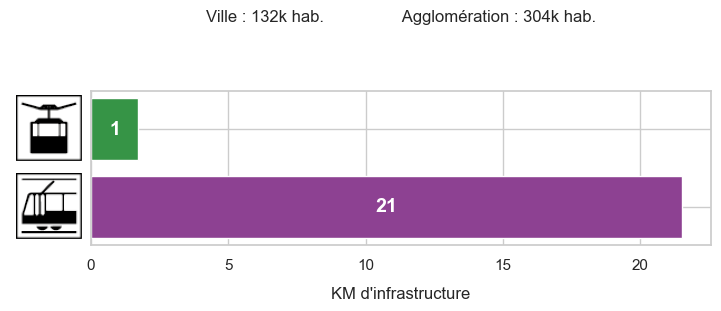

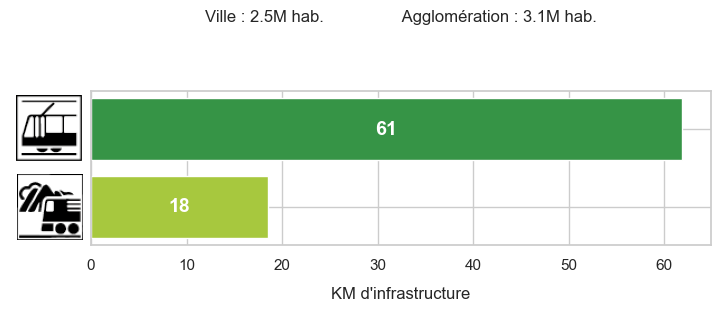

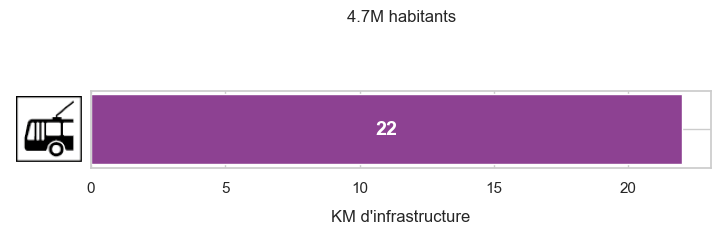

In [133]:
for ville in df["Ville"].unique():
    df_ville = df[df["Ville"] == ville]
    grouped = df_ville.groupby(["Mode de transport", "Situation en 2024"])
    
    # Trier les groupes selon l'ordre défini
    sorted_groups = sorted(grouped.groups.keys(), key=lambda x: situation_order.index(x[1]))
    
    # Initialisation des bases de hauteur pour le stacking
    bottoms = {}
    
    fig, ax = plt.subplots(figsize=(8, len(df_ville["Mode de transport"].unique())))

    
    for (mode, situation) in sorted_groups:
        group = grouped.get_group((mode, situation))
        key = mode  # Empilage par mode de transport
        base = bottoms.get(key, 0)  # Hauteur de départ pour la pile
        
        for i, row in group.iterrows():
            ax.barh(
                mode,  # Une barre par mode de transport
                row["KM d'infrastructure"], 
                color=row["color"], 
                left=base,  # Empilage horizontal
                label=row["Situation en 2024"] if row["Situation en 2024"] not in ax.get_legend_handles_labels()[1] else ""
            )
            
            # Ajouter une étiquette de valeur à côté de chaque segment
            ax.text(base + row["KM d'infrastructure"] / 2, mode, 
                    int(row["KM d'infrastructure"]), 
                    va='center', ha='center', fontsize=14, color='white', fontweight='bold')
            
            base += row["KM d'infrastructure"]  # Mise à jour de la hauteur pour la pile
        
        bottoms[key] = base  # Mise à jour du bas pour ce mode de transport
    
    # Remplacement des labels par des icônes
    yticks = ax.get_yticks()
    for tick, mode in zip(yticks, df_ville["Mode de transport"].unique()):
        if mode in mode_icons:
            icon_path = mode_icons[mode]
            img = mpimg.imread(icon_path)
            imagebox = OffsetImage(img, zoom=0.8)
            ab = AnnotationBbox(imagebox, (0, tick), frameon=False, xybox=(-30, 0), xycoords='data', boxcoords='offset points')
            ax.add_artist(ab)
    
    ax.set_yticklabels([])  # Supprimer les textes des labels Y
    
    # Ajout des labels et titre
    ax.set_xlabel("KM d'infrastructure", labelpad = 10)
    str_population = row['hab_ville'] + " habitants" if row['hab_ville'] == row['hab_agglo'] else f"Ville : {row['hab_ville']} hab.                 Agglomération : {row['hab_agglo']} hab." 
    ax.set_title(str_population, pad = 50)   
    plt.savefig(os.path.join(path_img_fr, ville + ".png"), dpi=200, bbox_inches="tight")
    # Affichage du graphique
    plt.show()


In [205]:
# Mise à jour du geojson pour leaflet :
features = []

for idx, row in df_geodata.iterrows():
        ville = row['Name']
    
        # couleur : état le plus avancé, tout transports confondus
        df_ville = df_excel[df_excel['Ville'] == ville]
        if len(df_ville) > 0:
            df_ville["Situation en 2024"] = pd.Categorical(df_ville["Situation en 2024"], categories=situation_order, ordered=True)
            df_sorted = df_ville.sort_values("Situation en 2024")
        
            color = palette.get(df_sorted.iloc[-1]['Situation en 2024'])
        
            if ville in df_excel['Ville'].unique():
                feature = geojson.Feature(
                        geometry=geojson.Point((float(row["x"]), float(row["y"]))),
                        properties={
                            "name": ville,
                            "img_path": "img/fr/" + ville + ".png",
                            "color" : color
                        },
                    )
            
                features.append(feature)


feature_collection = geojson.FeatureCollection(features)

# Sauvegarder dans un fichier GeoJSON
with open(path_geojson, "w") as f:
    geojson.dump(feature_collection, f)

C:\Users\ade\AppData\Local\Temp\ipykernel_38288\2958305345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ville["Situation en 2024"] = pd.Categorical(df_ville["Situation en 2024"], categories=situation_order, ordered=True)
